# Importar bibliotecas

In [1]:
import sys
sys.path.append('JetTagging')
sys.path.append('JetTagging/src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Preprocessing.JetPreprocessing import PreprocessingJetImages
from Preprocessing.LabelsGeneration import create_jet_labels_one_column_per_category
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPool2D #Dense = MPLNN
from keras.optimizers import Adam, schedules
from utilities.utilities import save_model
from itertools import cycle

ModuleNotFoundError: No module named 'Preprocessing'

# Leitura de dados

In [2]:
data_gluon_train = pd.read_csv("../Dados/DataJetTagging/Trainning/g_jets.csv", header=None)
data_quark_train = pd.read_csv("../Dados/DataJetTagging/Trainning/q_jets.csv", header=None)
data_top_train = pd.read_csv("../Dados/DataJetTagging/Trainning/t_jets.csv", header=None)

data_gluon_val = pd.read_csv("../Dados/DataJetTagging/Validation/g_jets.csv", header=None)
data_quark_val = pd.read_csv("../Dados/DataJetTagging/Validation/q_jets.csv", header=None)
data_top_val = pd.read_csv("../Dados/DataJetTagging/Validation/t_jets.csv", header=None)

data_gluon_test = pd.read_csv("../Dados/DataJetTagging/Test/g_jets.csv", header=None)
data_quark_test = pd.read_csv("../Dados/DataJetTagging/Test/q_jets.csv", header=None)
data_top_test = pd.read_csv("../Dados/DataJetTagging/Test/t_jets.csv", header=None)

# Construção dos jatos e geração das imagens

In [3]:
jet_image_processing = PreprocessingJetImages(phi_range=(-0.4, 0.4), eta_range=(-0.4, 0.4), n_bins_phi=16, n_bins_eta=16)

In [4]:
top_images_train = jet_image_processing.transform(X=data_top_train.to_numpy())
quark_images_train = jet_image_processing.transform(X=data_quark_train.to_numpy())
gluon_images_train = jet_image_processing.transform(X=data_gluon_train.to_numpy())

top_images_val = jet_image_processing.transform(X=data_top_val.to_numpy())
quark_images_val = jet_image_processing.transform(X=data_quark_val.to_numpy())
gluon_images_val = jet_image_processing.transform(X=data_gluon_val.to_numpy())

top_images_test = jet_image_processing.transform(X=data_top_test.to_numpy())
quark_images_test = jet_image_processing.transform(X=data_quark_test.to_numpy())
gluon_images_test = jet_image_processing.transform(X=data_gluon_test.to_numpy())

In [5]:
all_jet_images_train = np.vstack([top_images_train, quark_images_train[: int(len(quark_images_train) / 2) + 1], gluon_images_train[: int(len(gluon_images_train)/2) + 1]])
all_jet_images_val = np.vstack([top_images_val, quark_images_val[: int(len(quark_images_val) / 2) + 1], gluon_images_val[: int(len(gluon_images_val)/2) + 1]])
all_jet_images_test = np.vstack([top_images_test, quark_images_test[: int(len(quark_images_test) / 2) + 1], gluon_images_test[: int(len(gluon_images_test)/2) + 1]])

In [6]:
jet_labels_train = create_jet_labels_one_column_per_category([(0, len(top_images_train) - 1), (len(top_images_train), len(all_jet_images_train) - 1)])
jet_labels_val = create_jet_labels_one_column_per_category([(0, len(top_images_val) - 1), (len(top_images_val), len(all_jet_images_val) - 1)])
jet_labels_test = create_jet_labels_one_column_per_category([(0, len(top_images_test) - 1), (len(top_images_test), len(all_jet_images_test) - 1)])

# Particionamento dos dados

In [7]:
x, y = shuffle(all_jet_images_train, jet_labels_train, random_state = 0)
vx, vy = shuffle(all_jet_images_val, jet_labels_val, random_state = 0)
tx, ty = shuffle(all_jet_images_test, jet_labels_test, random_state = 0)

x = x.reshape(-1,16,16,1)
vx = vx.reshape(-1,16,16,1)
tx = tx.reshape(-1,16,16,1)

# Construção da rede

In [14]:
#Montando a topologia da rede

nn = Sequential() #Rede sequencial
#especificamos as camadas da rede nn1
nn.add(Input(shape=(16,16,1)))
nn.add(Conv2D(filters = 128, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn.add(MaxPool2D(pool_size=(2,2)))
nn.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', activation ='relu'))
nn.add(MaxPool2D(pool_size=(2,2)))

# Aqui vai uma camada totalmente conectada
nn.add(Flatten()) #Traduz uma matriz de várias dimensões em uma matriz linear (um vetor)
nn.add(Dense(256, activation = "relu"))
nn.add(Dense(256, activation = "relu"))
nn.add(Dense(2, activation = "softmax"))
#topologia montada

# adicionando o otimizador
lr_schedule = schedules.ExponentialDecay(initial_learning_rate = 0.00005, decay_steps = 19870, decay_rate = 0.5, staircase = True)
optimizer = Adam(learning_rate=lr_schedule) #Adam é um backpropagation, mas com busca de mínimo otimizada

nn.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy", "auc"]) #Avisa o keras que essa é a nossa rede

In [15]:
epochs = 50
batch_size = 128

In [18]:
treino = nn.fit(x,y, epochs = epochs, validation_data = (vx, vy), batch_size = batch_size )

Epoch 1/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 278s 140ms/step - accuracy: 0.8589 - auc: 0.9269 - loss: 0.3439 - val_accuracy: 0.8687 - val_auc: 0.9421 - val_loss: 0.3100
Epoch 2/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 278s 140ms/step - accuracy: 0.8685 - auc: 0.9401 - loss: 0.3131 - val_accuracy: 0.8689 - val_auc: 0.9417 - val_loss: 0.3112
Epoch 3/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 286s 144ms/step - accuracy: 0.8725 - auc: 0.9431 - loss: 0.3047 - val_accuracy: 0.8771 - val_auc: 0.9479 - val_loss: 0.2921
Epoch 4/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 298s 150ms/step - accuracy: 0.8754 - auc: 0.9450 - loss: 0.2997 - val_accuracy: 0.8780 - val_auc: 0.9480 - val_loss: 0.2920
Epoch 5/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 278s 140ms/step - accuracy: 0.8767 - auc: 0.9465 - loss: 0.2957 - val_accuracy: 0.8804 - val_auc: 0.9507 - val_loss: 0.2847
Epoch 6/50
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 286s 144ms/step - accuracy: 0.8763 - auc: 0.9463 - loss: 0.2961 - val_accuracy: 0.8783 - val_auc: 0.9491 - val_loss: 0.2896
Epoc

In [19]:
nome = 'top-tagger-final'
save_model(nn, treino, nome)

# Avaliação da rede

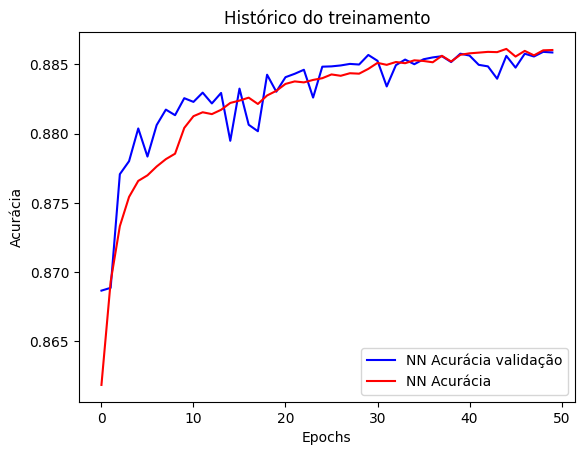

In [20]:
# Plot the loss and accuracy curves for training and validation
plt.plot(treino.history['val_accuracy'], color='b', label="NN Acurácia validação")
plt.plot(treino.history['accuracy'], color='r', label="NN Acurácia")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

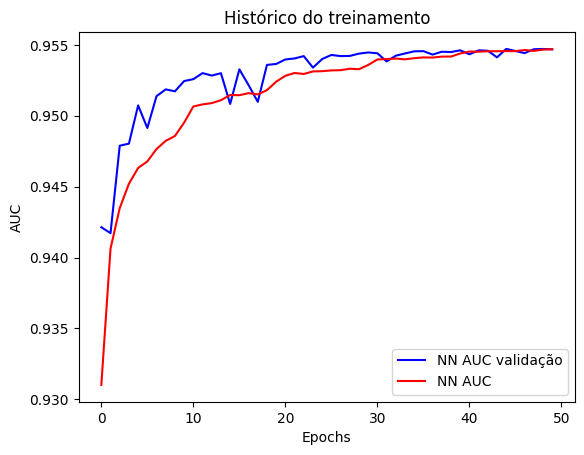

In [21]:
# Plot the AUC and accuracy curves for training and validation
plt.plot(treino.history['val_auc'], color='b', label="NN AUC validação")
plt.plot(treino.history['auc'], color='r', label="NN AUC")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [22]:
y_pred = nn.predict(tx)

1650/1650 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step


In [23]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ty[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [24]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

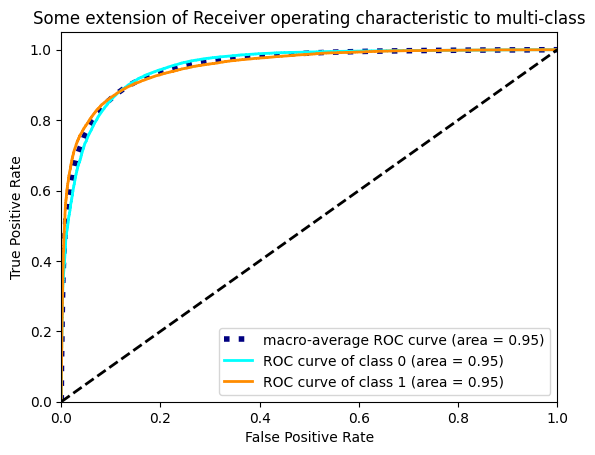

In [25]:
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()